# Long-$n$ Rydberg Scan

### Configure Ipython

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from positronium import Bohr
%matplotlib inline
#import custom packages
import sspals, oskar
import f2mods as f2

### Import Data

In [2]:
rid = '20160311_191136'
h5 = oskar.h5_data(rid)             # data
h5.load_log()
out_dire = h5.out_dire("Analysis")  # output

In [3]:
#read data
DF = h5.load_av(verbose=True, loop=True, exclude=['avL_SSPALS.dat', 
                                                    'avL_SSPALS_CH_L0[ -1.00e-08   2.20e-07   6.50e-07].dat'])
DF.head()

Loaded: avL_SSPALS_CH_L2[ -1.00e-08   5.00e-07   1.05e-06].dat
Loaded: av_SSPALS.dat


,DLY_EA,IR,VOL_u100,VOL_u101,t0_ra_reps,t0_ra_mean,t0_ra_std,t0_ra_sem,DF_ra_reps,DF_ra_mean,...,DF_std,DF_sem,Range_reps,Range_mean,Range_std,Range_sem,FWHM_reps,FWHM_mean,FWHM_std,FWHM_sem
VID,,,,,,,,,,,,,,,,,,,,,
1,5.950000e-07,728.13,2000,2000,180,2.401531e-07,2.217816e-10,1.653062e-11,180,0.023134,...,0.007268,0.000542,180,0.320926,0.039383,0.002935,180,9.967088e-09,5.881032e-10,4.383462e-11
2,5.950000e-07,728.16,2000,2000,180,2.401364e-07,2.423251e-10,1.806185e-11,180,0.022926,...,0.007488,0.000558,180,0.325412,0.037656,0.002807,180,1.001895e-08,5.628591e-10,4.195304e-11
3,5.950000e-07,728.19,2000,2000,180,2.400716e-07,2.673880e-10,1.992993e-11,180,0.022954,...,0.008198,0.000611,180,0.324620,0.038857,0.002896,180,9.961446e-09,5.498930e-10,4.098660e-11
4,5.950000e-07,728.22,2000,2000,180,2.400869e-07,2.522100e-10,1.879863e-11,180,0.022963,...,0.007192,0.000536,180,0.333647,0.040679,0.003032,180,1.006691e-08,5.542544e-10,4.131169e-11
5,5.950000e-07,728.25,2000,2000,180,2.401929e-07,2.342521e-10,1.746012e-11,180,0.022873,...,0.007550,0.000563,180,0.323946,0.035337,0.002634,180,9.963903e-09,5.395491e-10,4.021562e-11


## Plot Data

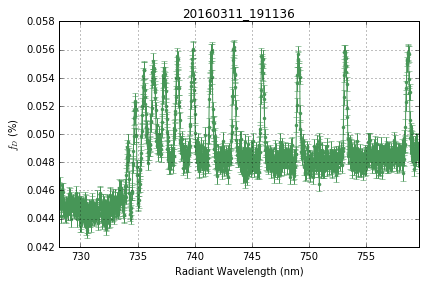

In [20]:
X = 'IR'
Y = 'DF'
#plot setup
fig, ax = plt.subplots()

sg = DF.sort_values(by=X)
x = sg[X].values
y = sg[Y+'_mean'].values
yerr = sg[Y+'_sem'].values
ax.errorbar(x, y, yerr=yerr, fmt ='.-', color=oskar.colors[1])

#format
ax.set_ylabel("$f_{D}$ (%)")
ax.set_xlabel("Radiant Wavelength (nm)")
ax.set_xlim(x.min(), x.max())
ax.grid(True)
ax.set_title(rid)
plt.tight_layout()

#save data
fileout = os.path.join(out_dire, "long_n_DF.png")
plt.savefig(fileout, dpi=150, bbox_inches='tight')
plt.show()

## Signal

In [21]:
#calculate signal 
back = DF[(DF[X] > 750) & (DF[X] < 753)][Y+'_mean'] #define background
bk = back.mean()
bk_sem = back.std()/np.sqrt(back.count())
sig = sspals.signal(DF[Y+'_mean'], DF[Y+'_sem'], bk, bk_sem)
DF['S'] = sig[0]
DF['S_err'] = sig[1]

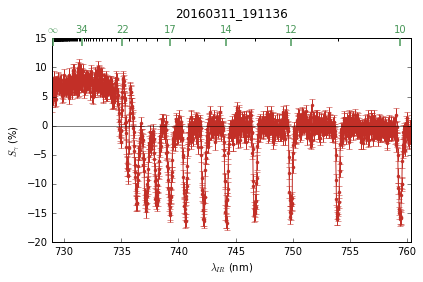

In [22]:
X = 'IR'
Y2 = 'S'
#plot setup
fig, ax = plt.subplots(figsize=(6, 4))

#plot
DF = DF.sort_values(by=X)
x = f2.rad_cal(DF[X].values)
y = DF[Y2].values
yerr = DF[Y2+'_err'].values
eb = ax.errorbar(x, y, yerr=yerr, fmt ='.-', color=oskar.colors[2])

#labels
ax.set_ylabel("$S_\gamma$ (%)")
ax.set_xlabel("$\lambda_{IR}$ (nm)")

ax.set_xlim(x.min(), x.max())
ax, ax_top, ticks = f2.ryd_ticks(ax, color = oskar.colors[1], unit='nm',
                          labels=[10, 12, 14, 17, 22, 34, float('inf')],
                          alt_labels=['10', '12', '14', '17', '22', '34', '$\infty$'])
ax_top.set_xlim(ax.get_xlim())
ax.axhline(0, alpha=0.5, c='k')

ax_top.tick_params(axis='both', which='major', length=8, width=1.5, color = oskar.colors[1])
ax_top.tick_params(axis='both', which='minor', length=3, width=1)

ax.set_title(rid, y=1.08)

#save data
plt.tight_layout()
fileout = os.path.join(out_dire, "long_n_S_pwo.png")
plt.savefig(fileout, dpi=150, bbox_inches='tight')
plt.show()

In [23]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

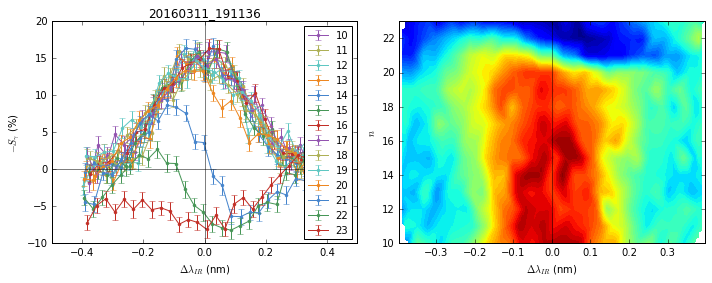

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
X = []; Y = []; Z = []
for n in np.arange(10, 24):
    xdat = x - Bohr.En(2, n, unit='nm')
    mask = (xdat > -0.4) & (xdat < 0.4)
    X.append(xdat[mask])
    ydat = -y[mask]
    Y.append(np.zeros_like(ydat) + n)
    Z.append(ydat)
    yer = yerr[mask]
    eb = ax[0].errorbar(xdat[mask], ydat, yerr=yer, fmt ='.-', color=oskar.colors[n%7], label=n)

x2 = np.concatenate(X)
y2 = np.concatenate(Y)
z2 = np.concatenate(Z)

X, Y, Z = grid(x2, y2, z2)
ax[1].contourf(X, Y, Z, 50)

#labels
ax[0].set_ylabel("$-S_\gamma$ (%)")
ax[0].set_xlabel("$\Delta \lambda_{IR}$ (nm)")
ax[0].set_xlim(-0.5, 0.5)
ax[0].legend(fontsize=10, numpoints=1)
ax[0].set_title(rid)
ax[0].axvline(0, c='k', alpha=0.5)
ax[0].axhline(0, c='k', alpha=0.5)
ax[1].set_ylabel("$n$")
ax[1].set_xlabel("$\Delta \lambda_{IR}$ (nm)")
ax[1].axvline(0, c='k', alpha=0.5)
#save data
plt.tight_layout()
fileout = os.path.join(out_dire, "deltaS_pwo.png")
plt.savefig(fileout, dpi=150, bbox_inches='tight')
plt.show()

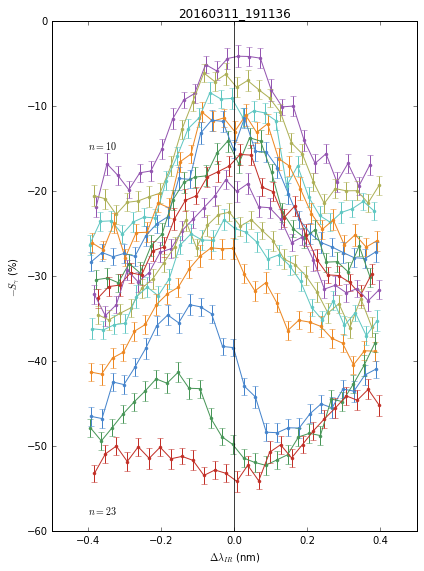

In [28]:
fig, ax = plt.subplots(figsize=(6, 8))
X = []; Y = []; Z = []
for n in np.arange(10, 24):
    xdat = x - Bohr.En(2, n, unit='nm')
    mask = (xdat > -0.4) & (xdat < 0.4)
    X.append(xdat[mask])
    ydat = -y[mask]
    Y.append(np.zeros_like(ydat) + n)
    Z.append(ydat)
    yer = yerr[mask]
    eb = ax.errorbar(xdat[mask], ydat - 2*n, yerr=yer, fmt ='.-', color=oskar.colors[n%7], label=n)


#labels
ax.set_ylabel("$-S_\gamma$ (%)")
ax.set_xlabel("$\Delta \lambda_{IR}$ (nm)")
ax.set_xlim(-0.5, 0.5)
ax.set_title(rid)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)

ax.axvline(0, c='k', alpha=0.5)

ax.text(-0.4, -15, '$n = 10$')
ax.text(-0.4, -58, '$n = 23$')
#save data
plt.tight_layout()
fileout = os.path.join(out_dire, "deltaS_jdiv_pwo.png")
plt.savefig(fileout, dpi=150, bbox_inches='tight')
plt.show()